---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
license: "CC BY"
copyright: 
  holder: Matthew Reda
  year: 2024
citation: true
---

# A Comparison of Normalization Techniques for Group Level Data

> How to handle panel data

In [ ]:
#| default_exp normalization

In [ ]:
#| export
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

In [ ]:
#| hide
from tueplots import bundles
from tueplots.constants.color import rgb
import warnings

In [ ]:
#| hide
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
#| hide
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#| hide
np.random.seed(42)
n_samples = 156
groups = ['A', 'B', 'C']
data = []
data_holdout = []

i = 0
for group in groups:
    X = np.exp(np.random.normal(1, .2, n_samples-56)+.2*i)
    noise = np.random.normal(0, .1, n_samples-56)
    Y = np.exp(0.5 * np.log(X) + i + noise)
    
    data.extend(zip([group]*(n_samples-56), X, Y))
    X = np.exp(np.random.normal(1, .2, 56)+.2*i)
    noise = np.random.normal(0, .1, 56)
    Y = np.exp(0.5 * np.log(X) + i + noise)
    data_holdout.extend(zip([group]*(56), X, Y))
    i += 1

df = pd.DataFrame(data, columns=['Group', 'X', 'Y'])
df_holdout = pd.DataFrame(data_holdout, columns=['Group', 'X', 'Y'])

In [ ]:
#| export
def perform_fixed_effects(
    df: pd.DataFrame, # Data
    dependent_var: str, # Dependent Variable Name
    independent_var: str, # Independent Variable Name
    group: None|str = None # Grouping Name
    ):
    X = sm.add_constant(df[independent_var])
    y = df[dependent_var]
    if not group is None:
        X = sm.add_constant(df[[independent_var]].join(pd.get_dummies(df[group], drop_first=True).astype(int)))
        model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': pd.factorize(df[group])[0]})
        print(model.summary())
        return model
        
    model = sm.OLS(y, X).fit()
    print(model.summary())
    return model

:::{.panel-tabset group=Regression}

## Linear Regression

In [ ]:
#| label: tbl-OLS-OD
#| tbl-cap: OLS Regression on Original Data
model_original = perform_fixed_effects(df, 'Y', 'X', group="Group")

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     321.0
Date:                Wed, 20 Nov 2024   Prob (F-statistic):            0.00310
Time:                        23:41:40   Log-Likelihood:                -400.16
No. Observations:                 300   AIC:                             808.3
Df Residuals:                     296   BIC:                             823.1
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2542      0.763     -1.644      0.1

In [ ]:
#| hide
df['log_X'] = np.log(df['X'])
df['log_Y'] = np.log(df['Y'])

## Log-Log Model No Div Normalize

In [ ]:
#| label: tbl-log-data
#| tbl-cap: OLS Regression on Log-Transformed Data
model_log = perform_fixed_effects(df, 'log_Y', 'log_X', "Group")

                            OLS Regression Results                            
Dep. Variable:                  log_Y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     49.98
Date:                Wed, 20 Nov 2024   Prob (F-statistic):             0.0194
Time:                        23:51:17   Log-Likelihood:                 269.61
No. Observations:                 300   AIC:                            -531.2
Df Residuals:                     296   BIC:                            -516.4
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0305      0.065      0.470      0.6

In [ ]:
#| hide
df['log_X_norm'] = df.groupby('Group')['log_X'].transform(lambda x: x)
df['log_Y_norm'] = df.groupby('Group')['log_Y'].transform(lambda x: x / x.mean())
df['log_Y_mean'] = df.groupby('Group')['log_Y'].transform(lambda x: x.mean())

## Log-Log with Div Normalization

In [ ]:
#| label: tbl-normed
#| tbl-cap: OLS Regression on Log-Transformed and Mean-Normalized Data
model_log_norm = perform_fixed_effects(df, 'log_Y_norm', 'log_X', 'Group')

                            OLS Regression Results                            
Dep. Variable:             log_Y_norm   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     4.051
Date:                Wed, 20 Nov 2024   Prob (F-statistic):              0.182
Time:                        23:53:36   Log-Likelihood:                 183.09
No. Observations:                 300   AIC:                            -358.2
Df Residuals:                     296   BIC:                            -343.4
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5718      0.213      2.688      0.0

:::

:::{.panel-tabset group=Regression}

## Linear Regression

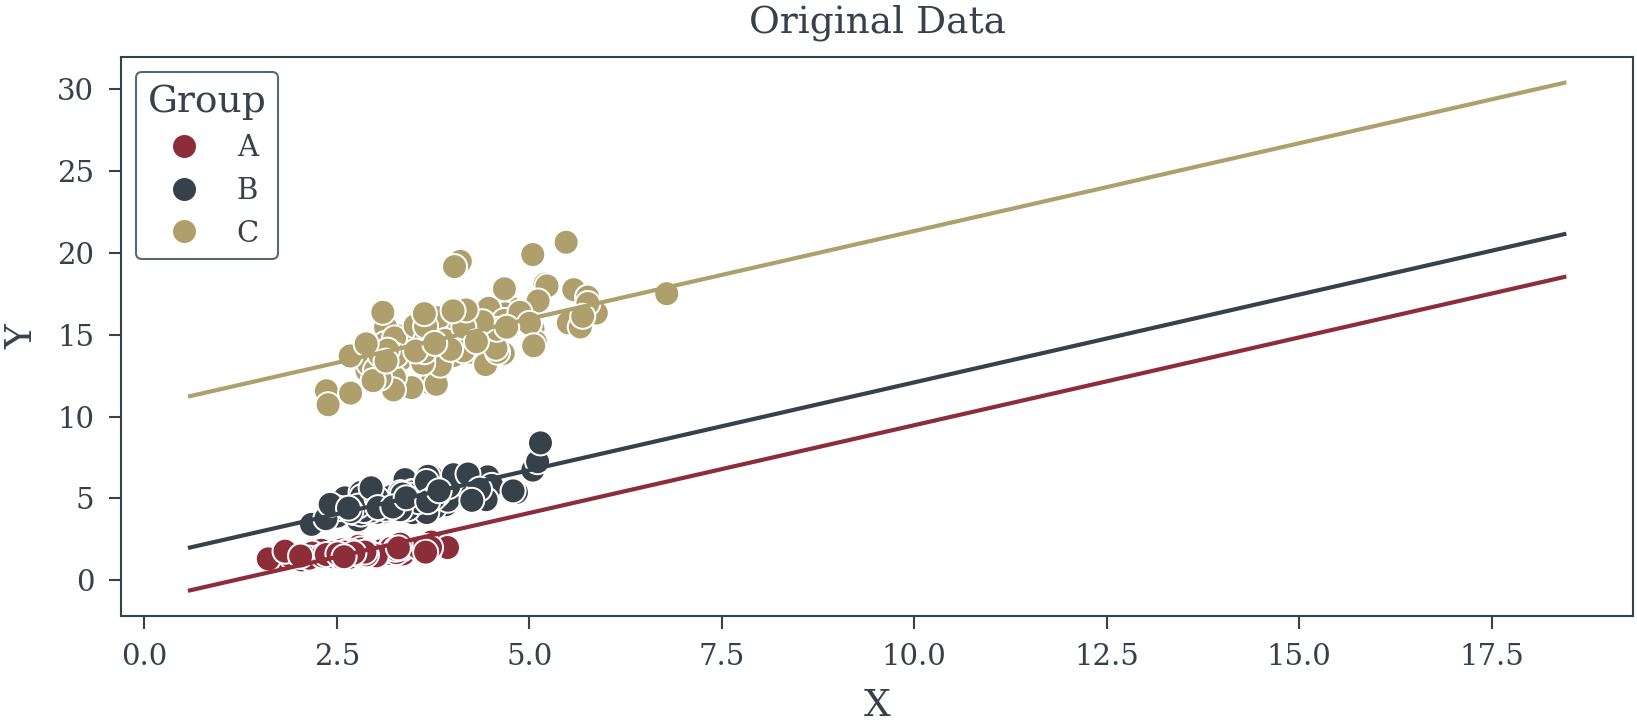

In [ ]:
#| echo: false
#| label: fig-model-comparison
#| fig-cap: Comparison of fit between models

# Original Data
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=df, x='X', y='Y', hue='Group')
X_pred = np.linspace(df['X'].min()/np.e, df['X'].max()*np.e, 100)
Y_pred_A = model_original.params.iloc[0] + model_original.params.iloc[1] * X_pred
Y_pred_B = model_original.params.iloc[0] + model_original.params.iloc[1] * X_pred + model_original.params.iloc[2]
Y_pred_C = model_original.params.iloc[0] + model_original.params.iloc[1] * X_pred + model_original.params.iloc[3]
ax.plot(X_pred, Y_pred_A, color='C0')
ax.plot(X_pred, Y_pred_B, color='C1')
ax.plot(X_pred, Y_pred_C, color='C2')
ax.set_title('Original Data');

## Log-Log Model No Div Normalize

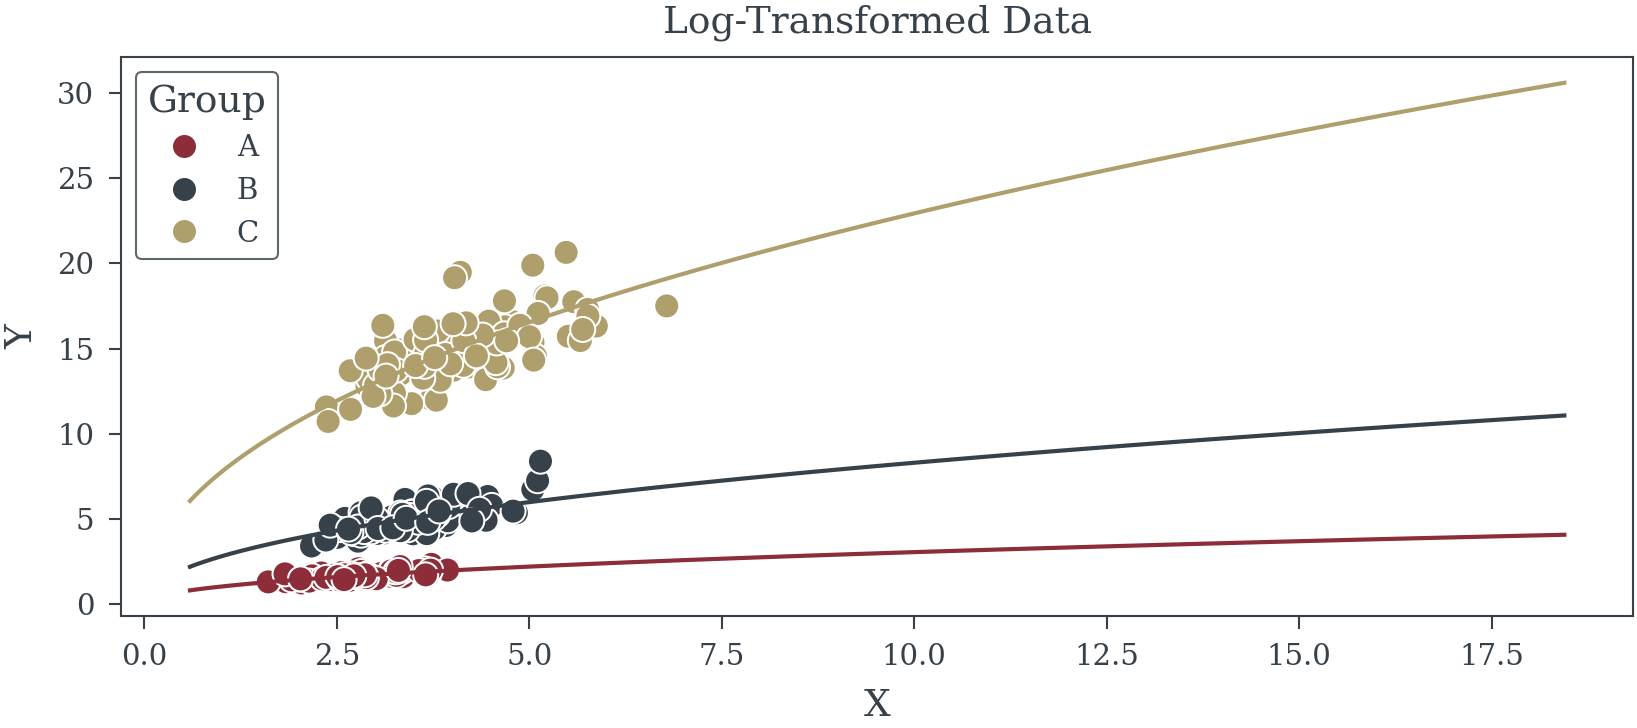

In [ ]:
#| echo: false
# Log-Transformed Data
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=df, x='X', y='Y', hue='Group')
X_pred_log = np.linspace(df['log_X'].min()-1, df['log_X'].max()+1, 100)
Y_pred_log_A = np.exp(model_log.params.iloc[0] + model_log.params.iloc[1] * X_pred_log)
Y_pred_log_B = np.exp(model_log.params.iloc[0] + model_log.params.iloc[1] * X_pred_log + model_log.params.iloc[2])
Y_pred_log_C = np.exp(model_log.params.iloc[0] + model_log.params.iloc[1] * X_pred_log + model_log.params.iloc[3])
ax.plot(np.exp(X_pred_log), Y_pred_log_A, color='C0')
ax.plot(np.exp(X_pred_log), Y_pred_log_B, color='C1')
ax.plot(np.exp(X_pred_log), Y_pred_log_C, color='C2')
ax.set_title('Log-Transformed Data');


## Log-Log with Div Normalization

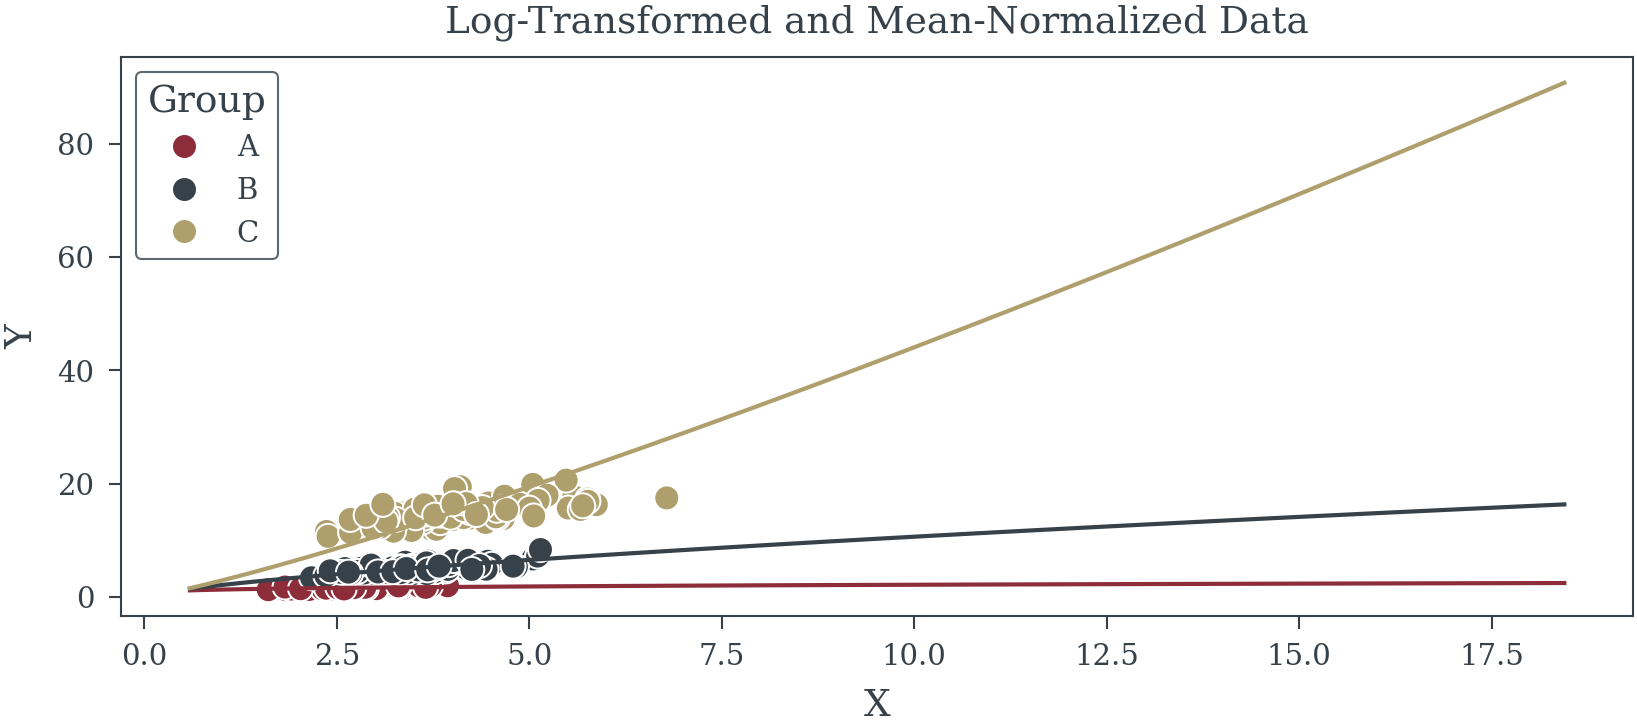

In [ ]:
#|echo: false
# Log-Transformed and Mean-Normalized Data
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=df, x='X', y='Y', hue='Group')
X_pred_log_norm = np.linspace(df['log_X'].min()-1, df['log_X'].max()+1, 100)
y_mean = df.groupby('Group')['log_Y'].mean()
y_mean_0 = y_mean.loc['A']
y_mean_1 = y_mean.loc['B']
y_mean_2 = y_mean.loc['C']
Y_pred_log_norm = (model_log_norm.params.iloc[0] + model_log_norm.params.iloc[1] * X_pred_log_norm)
ax.plot(np.exp(X_pred_log_norm), np.exp(y_mean_0*(Y_pred_log_norm)), color='C0')
ax.plot(np.exp(X_pred_log_norm), np.exp(y_mean_1*(Y_pred_log_norm + model_log_norm.params.iloc[2])), color='C1')
ax.plot(np.exp(X_pred_log_norm), np.exp(y_mean_2*(Y_pred_log_norm + model_log_norm.params.iloc[3])), color='C2')
ax.set_title('Log-Transformed and Mean-Normalized Data');

:::

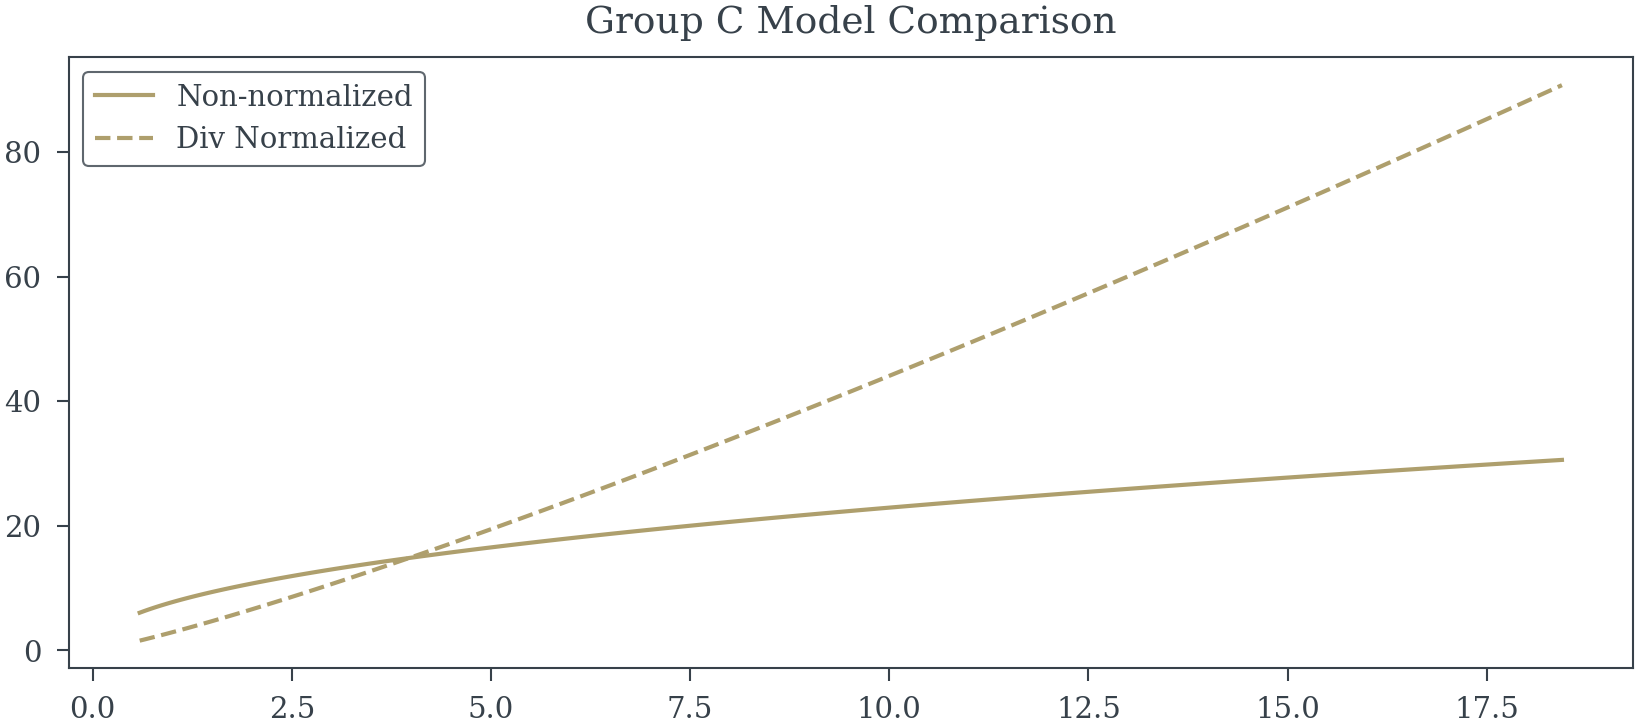

In [ ]:
#| echo: false
#| label: fig-model-comparison-C
#| fig-cap: Comparison of fit between models
plt.plot(np.exp(X_pred_log), Y_pred_log_C, color='C2', label='Non-normalized')
plt.plot(np.exp(X_pred_log_norm), np.exp(y_mean_2*(Y_pred_log_norm + model_log_norm.params.iloc[3])), color='C2', ls='--', label="Div Normalized")
#plt.plot(np.exp(X_pred_log_norm), (np.exp(y_mean_2*(Y_pred_log_norm + model_log_norm.params.iloc[3]))-Y_pred_log_C)/Y_pred_log_C, color='C1')
plt.title("Group C Model Comparison")
plt.legend();

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()